# Single Cell Sequencing
## Clustering


Uses exon data extracted from: zUMIs_output\expression\*.dgecounts.rds and gene data from: zUMIs_output\expression\*.gene_names.txt<br>
Performs clastering.<br>
Exports data to matlab.<br>

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
import hdf5plugin
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os 
#external modules
#pretty plotting
import seaborn as sb
import sys 
import warnings
warnings.filterwarnings("ignore")
sb.set_context(context='poster')

import copy

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.3 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.6 louvain==0.8.1 pynndescent==0.5.10


## SECTION I: Data loading
Loading adata information that has been agregated and quality controled

In [2]:
figure_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\figuresR'
input_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\out'

adata_path = os.path.join(input_path,'campari_scs_from_R.h5ad')
adata_all_path = os.path.join(input_path,'campari_scs_all_genes_from_R.h5ad')

campari_umap_file = 'control_scs_umap_from_R.h5ad'

matlab_matrix_file_name =  'control_from_ilona'


NO_PCA = 20 # maybe 20...


In [3]:
adata = ad.read_h5ad(adata_path)
adata_all = ad.read_h5ad(adata_all_path)

In [7]:
adata

AnnData object with n_obs × n_vars = 1706 × 16000
    obs: 'barcode', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

# Principal Component Analysis

In [8]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata, use_highly_variable=True, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


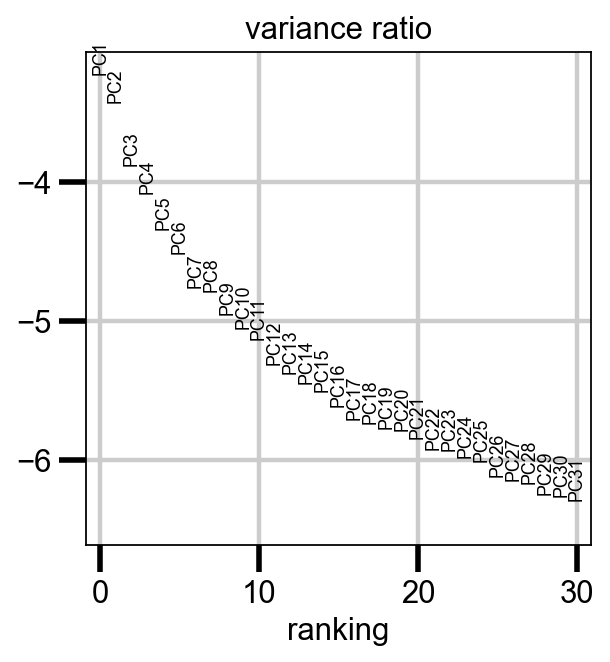

In [9]:
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function
sc.pl.pca_variance_ratio(adata, log=True)

# Computing the neighborhood graph

In [10]:
# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix
sc.pp.neighbors(adata, n_pcs=NO_PCA)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


# Embedding the neighborhood graph

In [11]:
# We suggest embedding the graph in two dimensions using UMAP 
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


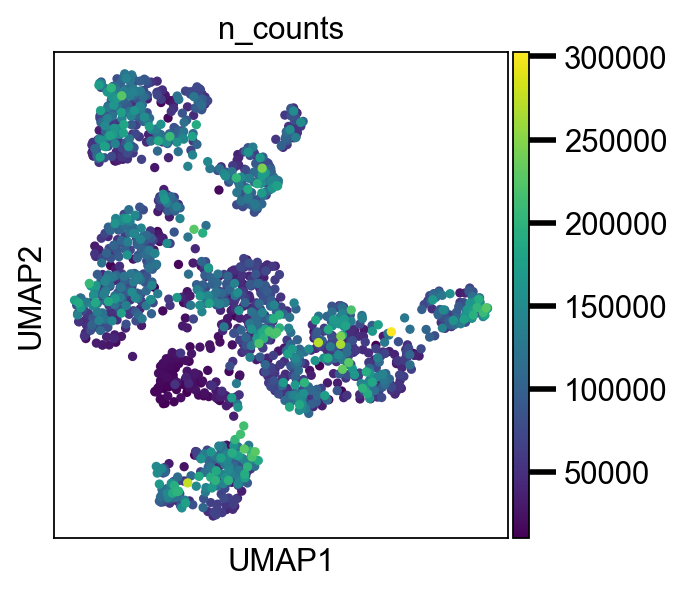

In [12]:
# You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw
sc.pl.umap(adata, color='n_counts', use_raw=False)

# Clustering the neighborhood graph

In [13]:
# Perform clustering - using highly variable genes
louvain_paramenters = [0.5,1,1.5,2,2.5]
louvain_names = []
for value in louvain_paramenters:
    louvain_names.append('louvain_r' + str(value))

for value,name in zip(louvain_paramenters,louvain_names):
    sc.tl.louvain(adata, resolution=value, key_added=name)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain_r1.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain_r2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain_r2.5', the cluster labels (adata.obs, categorical) (0:00:00)


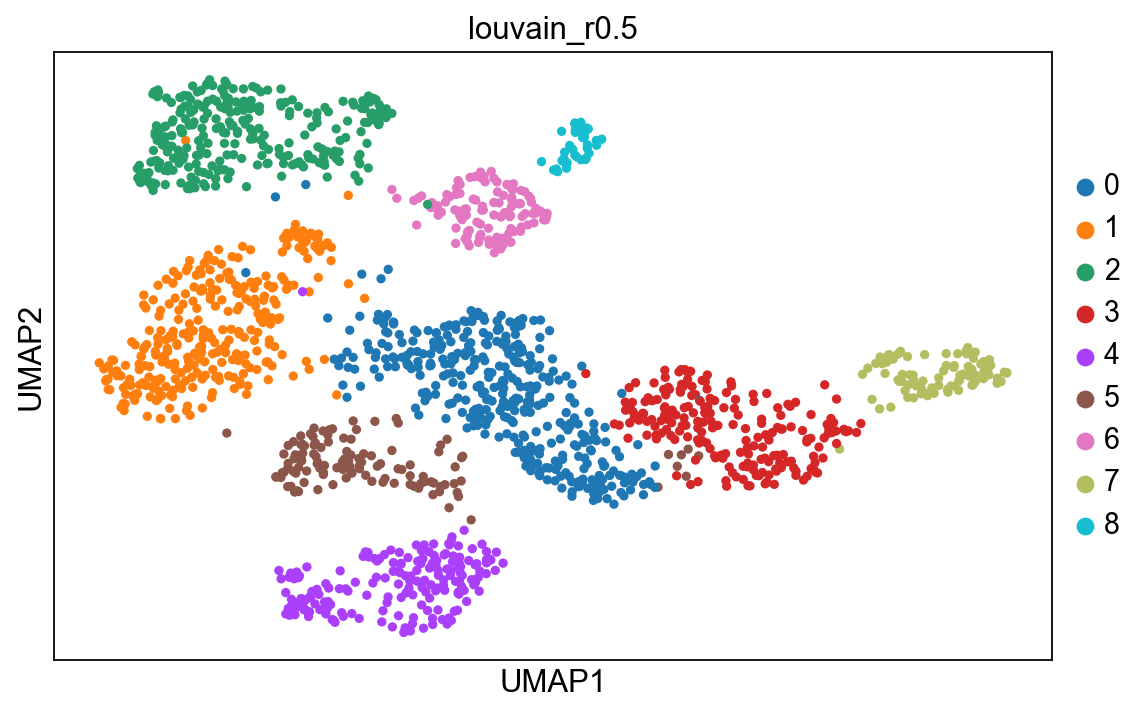

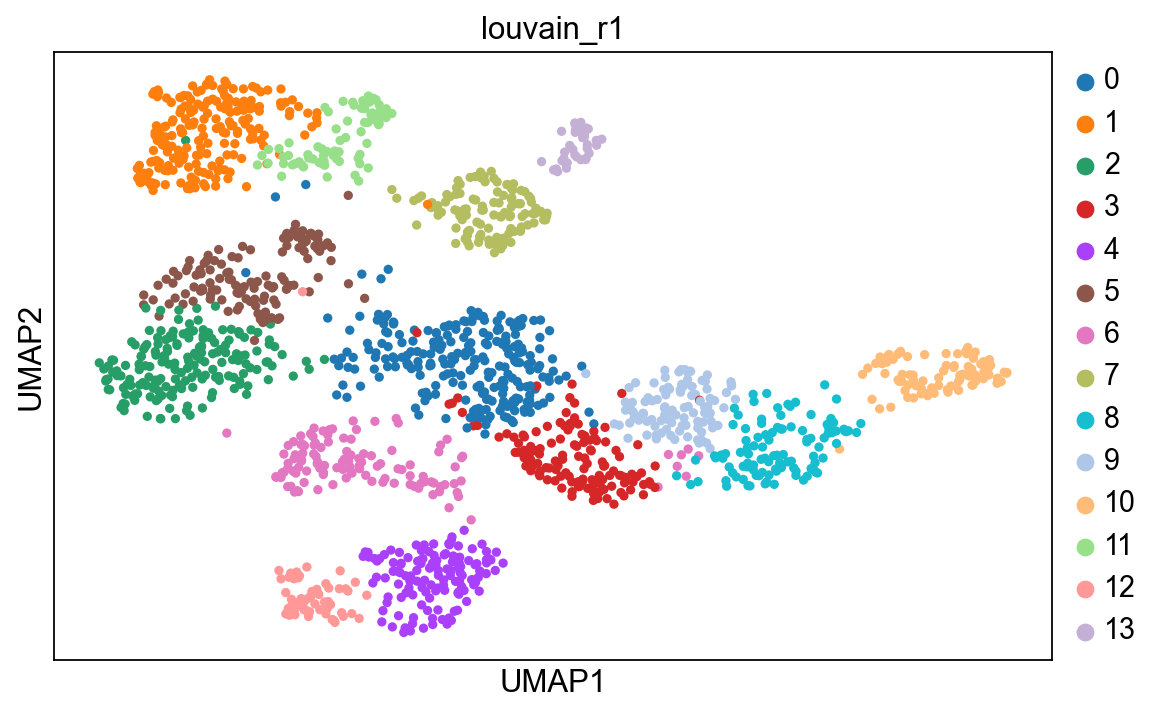

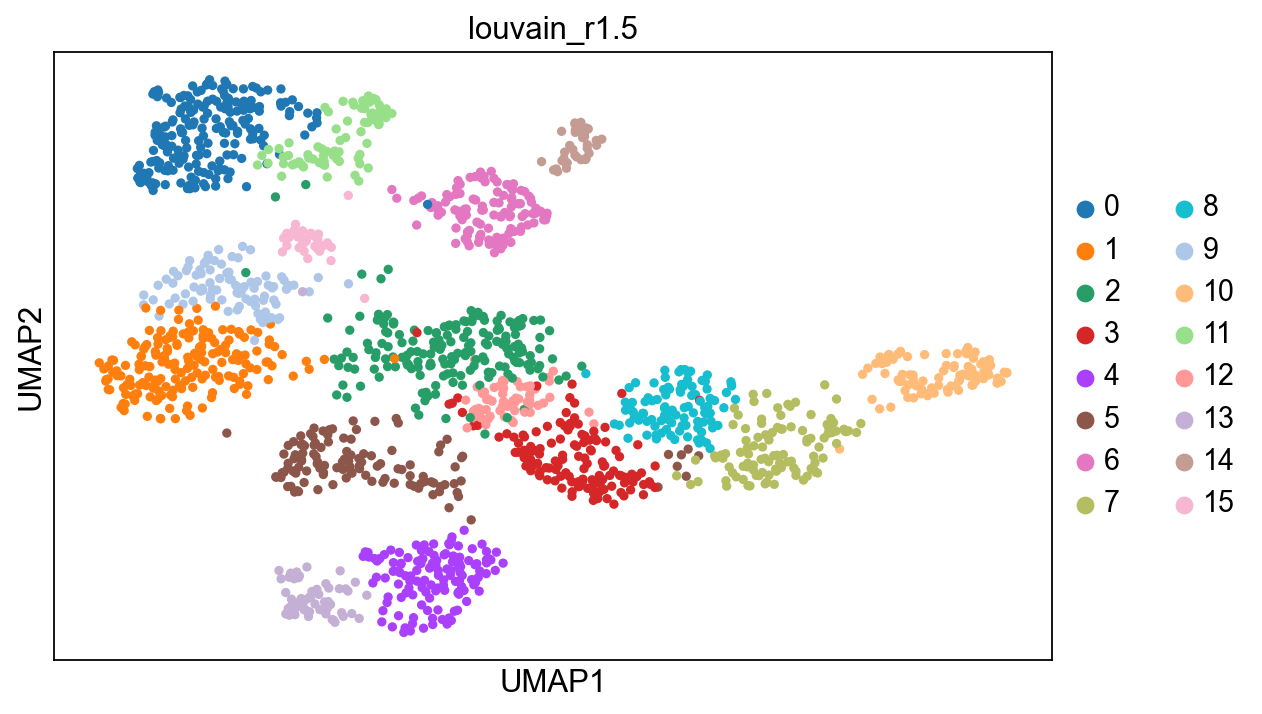

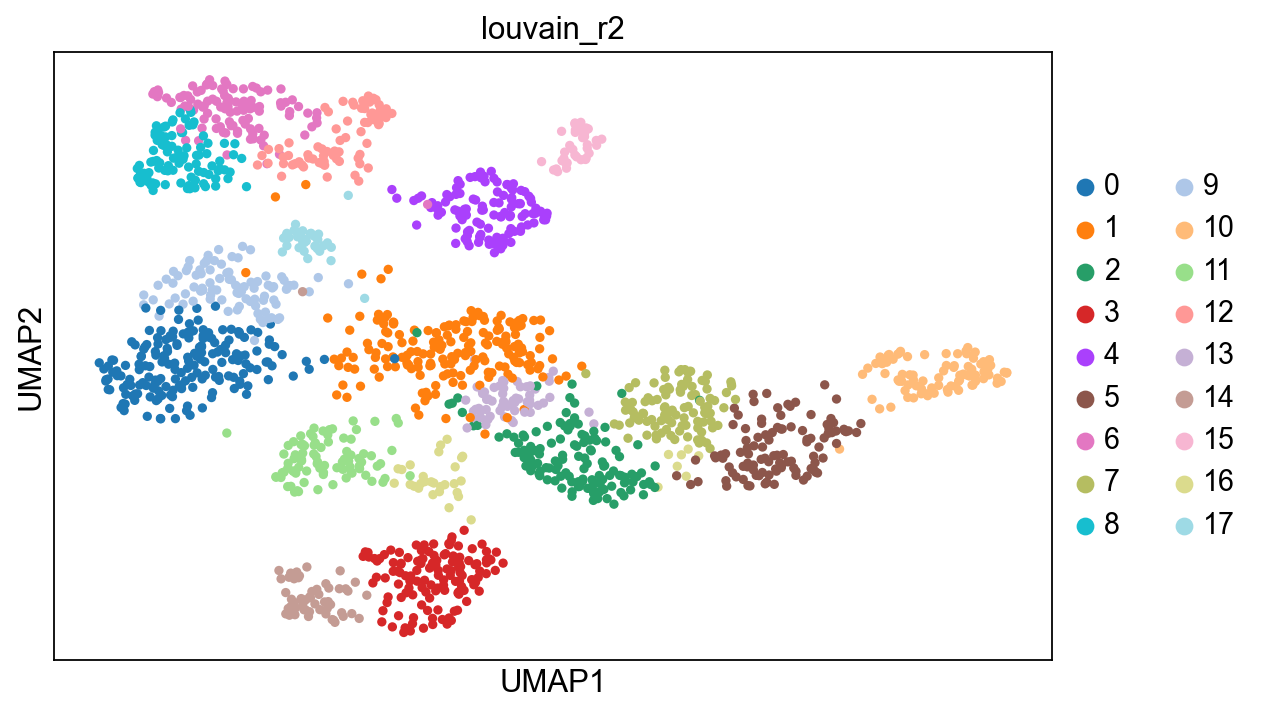

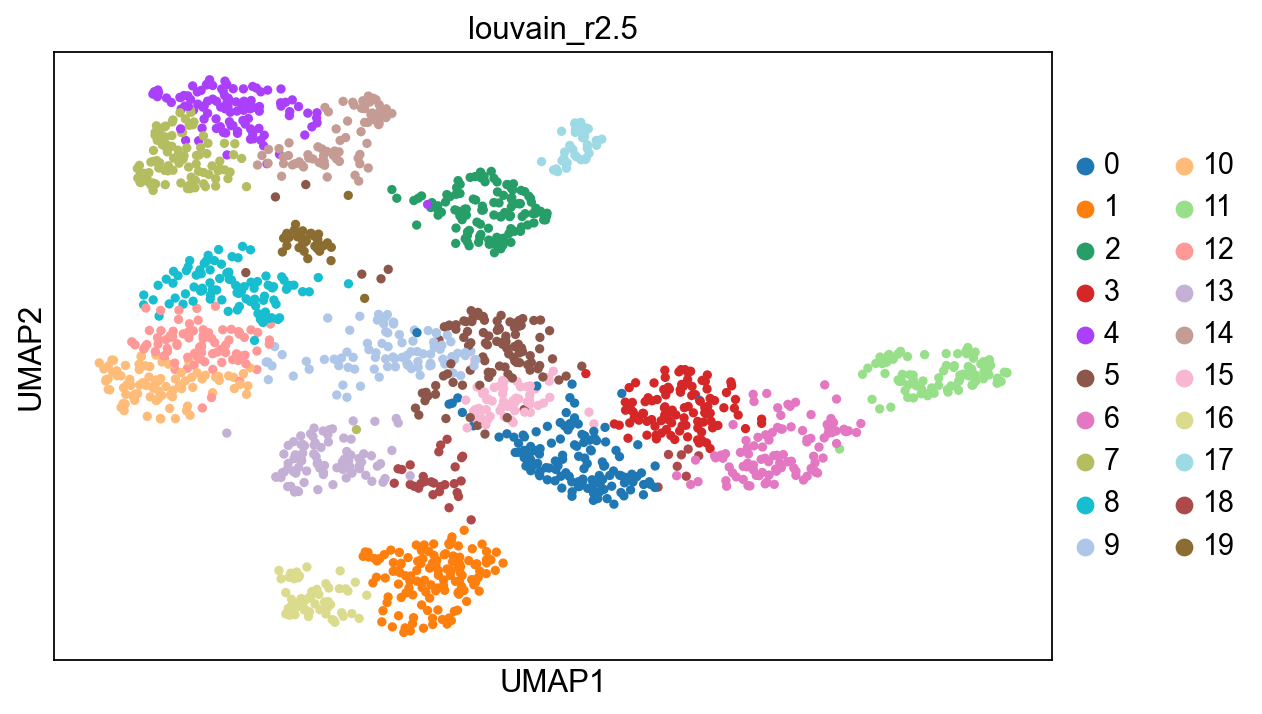

In [14]:
rcParams['figure.figsize']=(8,5)

# Visualize the clustering and how this is reflected by different technical covariates
for name in louvain_names:
    sc.pl.umap(adata, color=[name], use_raw=False, save = '_'+name + '.png')
    # sc.pl.umap(adata, color=[name,'n_counts'], use_raw=False, save = '_'+name + '.png')

In [15]:
# save umap data
adata.write_h5ad(
    os.path.join(input_path, campari_umap_file),
#    compression=hdf5plugin.FILTERS["zstd"],
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

## EXPORT DATA FOR MATLAB

Now we add the information we have about stimuli for each cell and level of campari green and red fluorecence. 

Here we define the stimuli that were used (this assignation of number and id is the one that is used in the plate information excel sheet): 

* 0: control
* 1: pinch
* 2: new_stroke (after december)
* 3: ballon
* 4: AG (ano-genital brush)
* 5: AD (anal distension)
* 6: heating
* 7: mock
* 8: old_stoke (first experiments with stroke)
* 9: anal pinch
* 10: mock with poop
* 11: vaginal distansion
* 12: tomatoe
* 13: poop
* 14: Bladder
* 15: Colon-rectum distension (CRD)
* 16: AD + CFA (anal distension + inflamation)
* 17: AGB + CFA (ano-genital brush + inflamation)
* 18: Heating + CFA (heating + inflamation)
* 19: Tail Brush
* 20: TRPM8 td Tomatoe

In [16]:
#################################################################################
#################################################################################
#################################################################################
#################### HERE WE EXPORT ALL THE INFORMATION AS .MAT ################

### we export sparse data matrix, stimuli and flourecence information, umap transformation information and
### louvain transformation

### create and exportable varable list of genes names
gene_name = []
for i in range(len(adata.var['gene_name'])):
    gene_name.append(adata.var['gene_name'].iloc[i])
    
gene_name_all = []
for i in range(len(adata_all.var['gene_name'])):
    gene_name_all.append(adata_all.var['gene_name'].iloc[i])
### transform adata sparse matrix to scipy
x_all = adata_all.X
x = adata.X
### create exportable arrays with information about stimuli, fluorecence, and louvain transformations
stim = np.zeros((x.shape[0],))
red = np.zeros((x.shape[0],))
green = np.zeros((x.shape[0],))
louvain = np.zeros((x.shape[0],len(louvain_names)))
for i in range(x.shape[0]):
    stim[i] = adata.obs['stimulus'][i]
    red[i] = adata.obs['red'][i]
    green[i] = adata.obs['green'][i]
    count = 0
    for name in louvain_names:
        louvain[i,count] = adata.obs[name][i]
        count = count + 1
data = {'umap': adata.obsm['X_umap'],'gene_name' : np.array(gene_name_all),'gene_name_matrix' : np.array(gene_name),'sparse_matrix': x_all,'matrix': x,'stimuli':stim,
        'red_intesity': red, 'green_intensity': green, 'louvain' : louvain, 'louvain_name': louvain_names}

from time import strftime
from datetime import datetime
today = datetime.now().strftime("%Y_%m_%d")
scipy.io.savemat(os.path.join(input_path , matlab_matrix_file_name+"_"+str(today)+'.mat'), data)

#################################################################################
#################################################################################
#################################################################################